Ultrasound Nerve Segmentation - Kaggle
=================================

The task in this competition is to segment a collection of nerves called the Brachial Plexus (BP) in ultrasound images. You are provided with a large training set of images where the nerve has been manually annotated by humans. Annotators were trained by experts and instructed to annotate images where they felt confident about the existence of the BP landmark.

Please note these important points:

The dataset contains images where the BP is not present. Your algorithm should predict no pixel values in these cases.
As with all human-labeled data, you should expect to find noise, artifacts, and potential mistakes in the ground truth. Any individual mistakes (not affecting the broader integrity of the competition) will be left as is.
Due to the way the acquisition machine generates image frames, you may find identical images or very similar images.
In order to reduce the submission file sizes, this competition uses run-length encoding (RLE) on the pixel values. The details of how to use RLE are described on the 'Evaluation' page.
File descriptions
/train/ contains the training set images, named according to subject_imageNum.tif. Every image with the same subject number comes from the same person. This folder also includes binary mask images showing the BP segmentations.
/test/ contains the test set images, named according to imageNum.tif. You must predict the BP segmentation for these images and are not provided a subject number. There is no overlap between the subjects in the training and test sets.
train_masks.csv gives the training image masks in run-length encoded format. This is provided as a convenience to demonstrate how to turn image masks into encoded text values for submission.
sample_submission.csv shows the correct submission file format.

The dataset can be obtained from https://www.kaggle.com/c/ultrasound-nerve-segmentation/data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = Path('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation')
path.ls()

[PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/test'),
 PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/test.zip'),
 PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/train.zip'),
 PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/train'),
 PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/sample_submission.csv'),
 PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/all.zip'),
 PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/submission.csv'),
 PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/train_masks.csv')]

In [4]:
path_train_img = path/'train/images'
path_train_lbl = path/'train/labels'
path_test_img = path/'test'

In [5]:
fnames = get_image_files(path_train_img)
fnames[:3]

[PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/train/images/41_110.tif'),
 PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/train/images/12_98.tif'),
 PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/train/images/7_19.tif')]

## Data

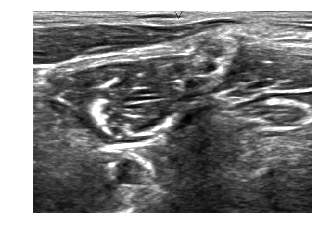

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [7]:
get_y_fn = lambda x : path_train_lbl/f'{x.stem}_mask.tif'

In [8]:
get_y_fn(img_f)

PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/train/labels/41_110_mask.tif')

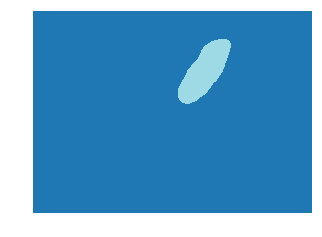

In [9]:
mask = open_mask(get_y_fn(img_f), div = True)
mask.show(figsize = (5,5), alpha = 1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([420, 580]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [11]:
torch.unique(mask.data)

tensor([1, 0])

In [12]:
codes = np.array(['non-bp','bp']); codes

array(['non-bp', 'bp'], dtype='<U6')

## Datasets

In [13]:
size = src_size//2
bs = 32
size

array([210, 290])

In [14]:
class SegmentationProcessor(PreProcessor):
    def __init__(self, ds:ItemList): self.classes = ds.classes
    def process(self, ds:ItemList):  ds.classes,ds.c = self.classes,len(self.classes)

class SegmentationLabelList(ImageItemList):
    _processor=SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.classes,self.loss_func = classes,CrossEntropyFlat()

    def new(self, items, classes=None, **kwargs):
        return self.__class__(items, ifnone(classes, self.classes), **kwargs)

    def open(self, fn): return open_mask(fn, div = True)
    def analyze_pred(self, pred, thresh:float=0.5): return pred.argmax(dim=0)[None]
    def reconstruct(self, t:Tensor): return ImageSegment(t)

class SegmentationItemList(ImageItemList): _label_cls = SegmentationLabelList

In [15]:
src = (SegmentationItemList.from_folder(path_train_img)
       .random_split_by_pct(0.2)
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

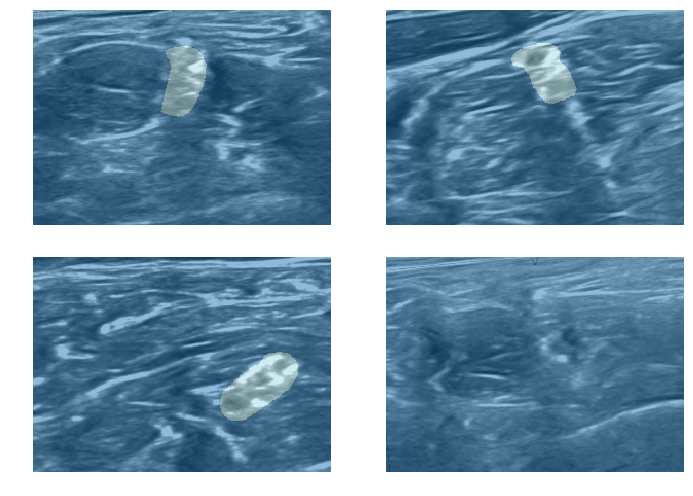

In [17]:
data.show_batch(2, figsize = (10,7))

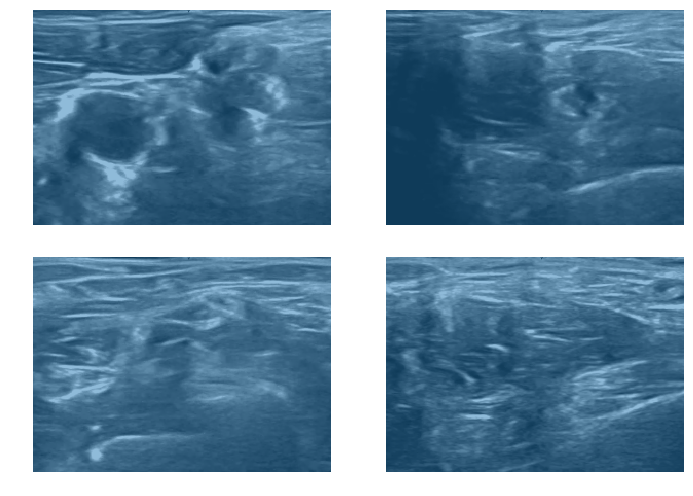

In [18]:
data.show_batch(2, figsize = (10,7), ds_type=DatasetType.Valid)

In [19]:
torch.unique(data.train_ds[0][1].data)

tensor([1, 0])

## Model

In [20]:
def dice(input:Tensor, targs:Tensor, iou:bool=False)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: 
        if torch.isnan(2. * intersect / union) > 0:
            return torch.isnan(2. * intersect / union).float()
        else:
            return 2. * intersect / union
    else: return intersect / (union-intersect+1.0)

In [21]:
metrics = dice

In [22]:
learn = Learner.create_unet(data,models.resnet34,metrics = metrics)

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


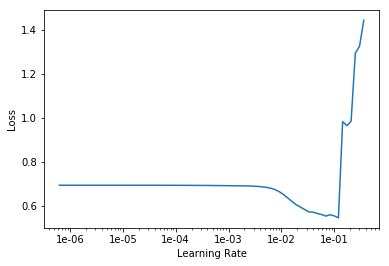

In [24]:
learn.recorder.plot()

In [25]:
lr = 1e-02

In [26]:
learn.fit_one_cycle(30, slice(lr))

Total time: 17:21
epoch  train_loss  valid_loss  dice    
1      0.173259    0.086034    0.000000  (00:37)
2      0.045698    0.099752    0.000000  (00:34)
3      0.036206    0.093844    0.000000  (00:35)
4      0.033814    0.094436    0.000000  (00:34)
5      0.031661    0.031276    0.413974  (00:34)
6      0.031658    0.030147    0.552375  (00:34)
7      0.031079    0.045701    0.553264  (00:34)
8      0.030700    0.039185    0.564882  (00:34)
9      0.030881    0.034139    0.586772  (00:34)
10     0.029107    0.028523    0.450987  (00:34)
11     0.028784    0.031805    0.600389  (00:34)
12     0.028541    0.028795    0.609392  (00:34)
13     0.027539    0.026359    0.568979  (00:34)
14     0.027829    0.028931    0.611406  (00:34)
15     0.026923    0.031529    0.609983  (00:34)
16     0.026000    0.030660    0.450325  (00:34)
17     0.026244    0.026944    0.607468  (00:34)
18     0.024796    0.028907    0.614151  (00:34)
19     0.024716    0.025586    0.591452  (00:34)
20     0.02

In [27]:
learn.save('stage-1')

In [28]:
learn.load('stage-1');

In [29]:
learn.unfreeze()

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


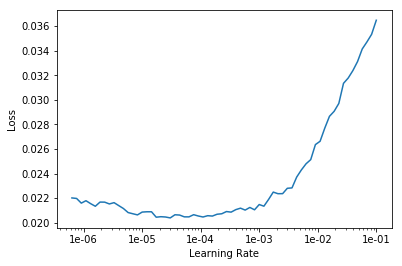

In [31]:
learn.recorder.plot()

In [32]:
lr = 1e-02

In [33]:
lrs = slice(2e-06, lr/5)

In [34]:
learn.fit_one_cycle(20, lrs)

Total time: 11:51
epoch  train_loss  valid_loss  dice    
1      0.020046    0.026511    0.613363  (00:35)
2      0.020447    0.026293    0.608843  (00:35)
3      0.021313    0.026970    0.616657  (00:35)
4      0.021137    0.026892    0.581518  (00:35)
5      0.021245    0.026897    0.613304  (00:35)
6      0.021963    0.026872    0.612311  (00:35)
7      0.021405    0.029561    0.620503  (00:35)
8      0.020902    283.884338  0.623877  (00:35)
9      0.021657    0.027075    0.620832  (00:35)
10     0.020388    0.027466    0.625421  (00:35)
11     0.019834    0.029437    0.610272  (00:36)
12     0.019862    0.027684    0.630202  (00:35)
13     0.019241    0.028236    0.618738  (00:36)
14     0.018777    0.028757    0.618331  (00:36)
15     0.018574    0.028718    0.619850  (00:36)
16     0.017475    0.031171    0.610924  (00:35)
17     0.017349    0.030484    0.614975  (00:35)
18     0.017029    0.031276    0.615143  (00:35)
19     0.017156    0.030875    0.615716  (00:35)
20     0.01

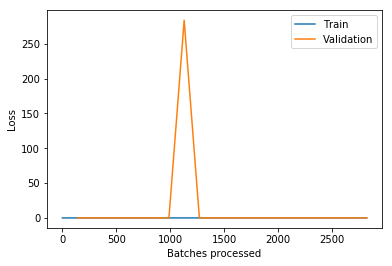

In [35]:
learn.recorder.plot_losses()

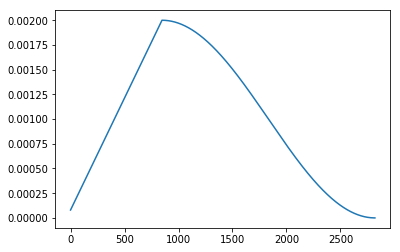

In [36]:
learn.recorder.plot_lr()

In [37]:
learn.save('stage-2');

In [39]:
learn.load('stage-2');

In [40]:
learn.fit_one_cycle(10, lrs)

Total time: 05:56
epoch  train_loss  valid_loss  dice    
1      0.016654    0.030637    0.616897  (00:35)
2      0.017588    0.032640    0.612329  (00:35)
3      0.017960    0.032975    0.591216  (00:35)
4      0.018526    0.029704    0.609871  (00:35)
5      0.018826    0.029158    0.591854  (00:35)
6      0.018353    0.029357    0.603548  (00:35)
7      0.016809    0.030884    0.599255  (00:35)
8      0.016708    0.030840    0.611204  (00:35)
9      0.015882    0.032680    0.607367  (00:35)
10     0.015604    0.032457    0.607320  (00:35)



In [41]:
learn.load('stage-2');

## Using Full Size

In [22]:
import gc; gc.collect()

8471

In [23]:
import torch
torch.cuda.empty_cache()

In [24]:
size = src_size
bs = 8
size

array([420, 580])

In [25]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [26]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [27]:
learn.load('stage-2');

In [28]:
learn.freeze()

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


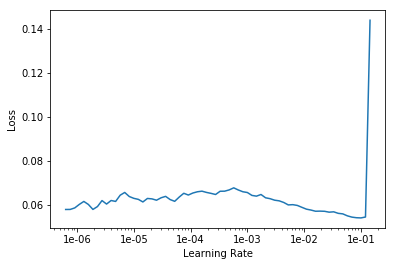

In [30]:
learn.recorder.plot()

In [27]:
lr = 1e-03

In [32]:
learn.fit_one_cycle(10, slice(lr))

Total time: 17:24
epoch  train_loss  valid_loss  dice    
1      0.035301    3.930951    0.452632  (01:50)
2      0.028272    0.025221    0.534297  (01:43)
3      0.026089    0.057312    0.592819  (01:43)
4      0.026368    0.040262    0.535926  (01:43)
5      0.024095    196.006027  0.562260  (01:43)
6      0.023556    929.758606  0.591336  (01:43)
7      0.022937    465.930176  0.606583  (01:43)
8      0.021506    104.839981  0.593856  (01:43)
9      0.022090    0.883032    0.594823  (01:44)
10     0.022100    9.774541    0.590972  (01:44)



In [33]:
learn.save('stage-1-big')

In [28]:
learn.load('stage-1-big');

In [31]:
learn.fit_one_cycle(20, slice(lr))

Total time: 34:05
epoch  train_loss  valid_loss  dice          
1      0.020976    152.976959  0.659325        (01:53)
2      0.022242    9142.148438  0.653529       (01:42)
3      0.021688    320.747223  0.662792        (01:42)
4      0.021383    0.112610    0.638667        (01:42)
5      0.022271    2491.735840  0.648949       (01:41)
6      0.022268    46311.703125  0.618657      (01:41)
7      0.020752    24275.912109  0.601355      (01:41)
8      0.019634    37.723812   0.623230        (01:41)
9      0.019235    47456836.000000  0.623282   (01:40)
10     0.019564    950.330078  0.579995        (01:40)
11     0.020286    424868.593750  0.625556     (01:41)
12     0.020242    480190176.000000  0.604803  (01:40)
13     0.018478    377878.656250  0.602175     (01:41)
14     0.019927    22328.320312  0.640777      (01:41)
15     0.017622    50379364.000000  0.637213   (01:41)
16     0.017846    425061.437500  0.608898     (01:42)
17     0.016636    583178.687500  0.641133     (01:42)
1

In [32]:
learn.fit_one_cycle(2, slice(lr))

Total time: 03:22
epoch  train_loss  valid_loss  dice    
1      0.019109    5.637270    0.605148  (01:41)
2      0.017956    781.559326  0.615486  (01:41)



In [33]:
learn.save('stage-2-big');

In [34]:
learn.fit_one_cycle(10, slice(lr))

Total time: 16:57
epoch  train_loss  valid_loss  dice      
1      0.017572    1007.150513  0.620049   (01:41)
2      0.019004    11438.179688  0.645910  (01:42)
3      0.018058    8045.414551  0.622327   (01:42)
4      0.018402    5053.689941  0.611966   (01:42)
5      0.017532    221.956268  0.629130    (01:41)
6      0.017325    2959.174316  0.616744   (01:41)
7      0.016960    2562.281006  0.610733   (01:41)
8      0.016704    5754.522461  0.619640   (01:41)
9      0.015518    4808.742188  0.597852   (01:40)
10     0.015359    18961.908203  0.617114  (01:41)



In [35]:
learn.save('stage-3-big');

In [29]:
learn.load('stage-3-big');

In [30]:
learn.unfreeze()

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


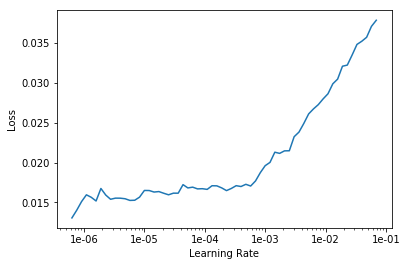

In [32]:
learn.recorder.plot()

In [27]:
lrs = slice(2e-06,2e-05)

In [34]:
learn.fit_one_cycle(20, lrs, wd=1e-3)

Total time: 38:37
epoch  train_loss  valid_loss  dice        
1      0.018010    6865.625488  0.731698     (02:01)
2      0.016948    1884479.625000  0.736527  (01:55)
3      0.015788    315449.750000  0.727575   (01:55)
4      0.015549    11190.879883  0.718264    (01:55)
5      0.017702    1773.710205  0.726330     (01:55)
6      0.017153    11432.502930  0.714805    (01:55)
7      0.016266    57748.175781  0.705217    (01:55)
8      0.016494    141366.140625  0.704085   (01:55)
9      0.015980    1906847.250000  0.716085  (01:55)
10     0.016092    5165.710938  0.710118     (01:55)
11     0.015901    4786.055176  0.709975     (01:55)
12     0.018002    18519.074219  0.707933    (01:55)
13     0.015839    6122.507812  0.704251     (01:55)
14     0.015467    875.888062  0.705523      (01:55)
15     0.016343    9469.839844  0.706312     (01:55)
16     0.015126    4227.431152  0.706567     (01:55)
17     0.014968    337.577942  0.697415      (01:55)
18     0.014617    8601.129883  0.697

In [35]:
learn.save('stage-4-big')

In [36]:
learn.load('stage-4-big');

In [37]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

Total time: 19:05
epoch  train_loss  valid_loss  dice        
1      0.013847    6594.655762  0.703656     (01:54)
2      0.014469    8987.376953  0.697926     (01:55)
3      0.014894    44632.445312  0.682581    (01:55)
4      0.015889    60631.410156  0.694059    (01:54)
5      0.014990    15743.311523  0.691157    (01:54)
6      0.014063    37493.949219  0.693380    (01:53)
7      0.014881    47522.500000  0.696049    (01:54)
8      0.014860    51129.414062  0.696002    (01:54)
9      0.014616    65656.390625  0.697143    (01:54)
10     0.013845    1105682.375000  0.697348  (01:54)



In [38]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

Total time: 19:04
epoch  train_loss  valid_loss  dice        
1      0.013296    826255.187500  0.696898   (01:53)
2      0.013285    14707.761719  0.694092    (01:54)
3      0.014526    6900980.500000  0.683771  (01:54)
4      0.014893    17663.197266  0.687175    (01:54)
5      0.014589    4540.495117  0.686232     (01:54)
6      0.014302    13114.373047  0.687502    (01:54)
7      0.014069    5620.467285  0.689861     (01:54)
8      0.012865    14802.881836  0.689544    (01:54)
9      0.014152    7476.586426  0.690171     (01:54)
10     0.013502    5889261.000000  0.685418  (01:54)



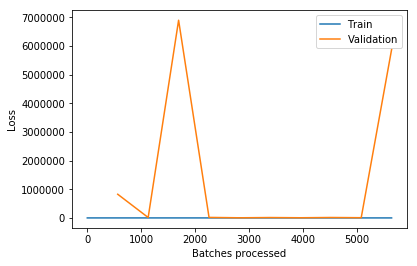

In [40]:
learn.recorder.plot_losses()

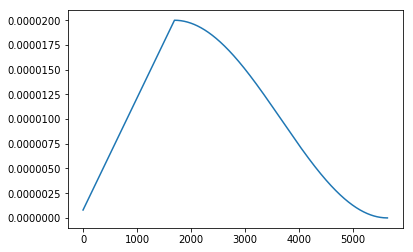

In [41]:
learn.recorder.plot_lr()

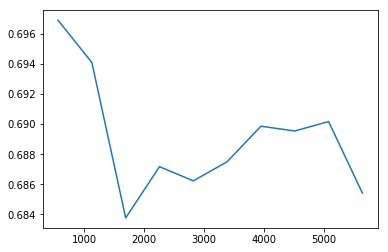

In [42]:
learn.recorder.plot_metrics()

It appears the dice metric did not improve.Hence reloading the previous weights.

In [28]:
learn.load('stage-4-big');

In [29]:
learn.fit_one_cycle(20, lrs, wd=1e-1)

Total time: 34:43
epoch  train_loss  valid_loss  dice       
1      0.015992    1462.031616  0.763185    (01:52)
2      0.014685    17999.287109  0.769178   (01:43)
3      0.015484    524.763245  0.768212     (01:43)
4      0.016230    680.122437  0.766051     (01:43)
5      0.015525    9535.259766  0.761343    (01:43)
6      0.017632    2422.914795  0.764968    (01:43)
7      0.016043    938.068542  0.764000     (01:43)
8      0.015995    325744.968750  0.761729  (01:43)
9      0.015935    4.272674    0.763013     (01:43)
10     0.015695    1068.383911  0.764613    (01:43)
11     0.015026    951.523499  0.770754     (01:43)
12     0.015396    1142.982422  0.766376    (01:43)
13     0.015426    3765.275391  0.766535    (01:44)
14     0.015349    776.643616  0.762546     (01:44)
15     0.015498    695.663025  0.767620     (01:43)
16     0.015344    6603.401367  0.768782    (01:44)
17     0.015821    9.439594    0.762815     (01:43)
18     0.015335    11175.167969  0.762428   (01:44)
19 

In [34]:
learn.save('stage-5-big')

In [35]:
learn.load('stage-5-big');

In [36]:
learn.fit_one_cycle(10, lrs, wd=1e-1)

Total time: 17:21
epoch  train_loss  valid_loss  dice     
1      0.014611    105.291466  0.765896   (01:43)
2      0.015211    651.835632  0.768579   (01:43)
3      0.015475    273.526489  0.760929   (01:43)
4      0.014817    1454.885376  0.765973  (01:43)
5      0.014878    3951.787842  0.759283  (01:43)
6      0.015759    644.643127  0.760883   (01:44)
7      0.015056    599.813538  0.763444   (01:44)
8      0.014503    1006.315979  0.767817  (01:44)
9      0.015035    1892.198730  0.766844  (01:44)
10     0.015239    1292.401001  0.766596  (01:44)



In [37]:
learn.save('stage-6-big')

In [38]:
learn.load('stage-6-big');

In [39]:
learn.fit_one_cycle(20, lrs, wd=1e+1)

Total time: 34:49
epoch  train_loss  valid_loss  dice    
1      0.015248    899.996704  0.763798  (01:43)
2      0.015237    108.412430  0.758566  (01:43)
3      0.016522    191.685425  0.754074  (01:43)
4      0.017213    139.027252  0.748408  (01:44)
5      0.017407    10.834346   0.747135  (01:44)
6      0.018569    0.015404    0.744432  (01:44)
7      0.021636    0.017139    0.760247  (01:44)
8      0.023566    0.019954    0.739683  (01:44)
9      0.026873    0.022548    0.741931  (01:44)
10     0.028321    0.025062    0.753147  (01:44)
11     0.029817    0.026497    0.760897  (01:45)
12     0.030745    0.028051    0.759067  (01:44)
13     0.031766    0.028362    0.752017  (01:44)
14     0.032353    0.028782    0.749443  (01:44)
15     0.032705    0.029415    0.743766  (01:44)
16     0.032544    0.029402    0.753439  (01:44)
17     0.032621    0.029855    0.753287  (01:44)
18     0.032579    0.029205    0.731805  (01:44)
19     0.032903    0.030308    0.768556  (01:44)
20     0.03

In [40]:
learn.save('stage-7-big')

In [81]:
learn.load('stage-7-big');

In [82]:
learn.fit_one_cycle(30, lrs, wd=1e+1)

Total time: 52:32
epoch  train_loss  valid_loss  dice    
1      0.032024    0.030113    0.754766  (01:43)
2      0.033423    0.029856    0.741332  (01:45)
3      0.032085    0.030538    0.757351  (01:45)
4      0.033698    0.030283    0.753057  (01:45)
5      0.032963    0.030699    0.767279  (01:44)
6      0.032577    0.030344    0.746341  (01:44)
7      0.032233    0.030219    0.709580  (01:44)
8      0.032005    0.030336    0.736726  (01:44)
9      0.031972    0.030107    0.721806  (01:44)
10     0.031450    0.029426    0.722447  (01:44)
11     0.031073    0.029620    0.715307  (01:45)
12     0.030854    0.028414    0.740483  (01:45)
13     0.030247    0.028213    0.713188  (01:45)
14     0.029844    0.027617    0.738360  (01:45)
15     0.031178    0.027547    0.736371  (01:45)
16     0.029556    0.027280    0.702378  (01:45)
17     0.030448    0.026651    0.736110  (01:45)
18     0.029816    0.026810    0.724864  (01:45)
19     0.029041    0.026413    0.733498  (01:45)
20     0.02

In [83]:
learn.save('stage-8-big')

## Results

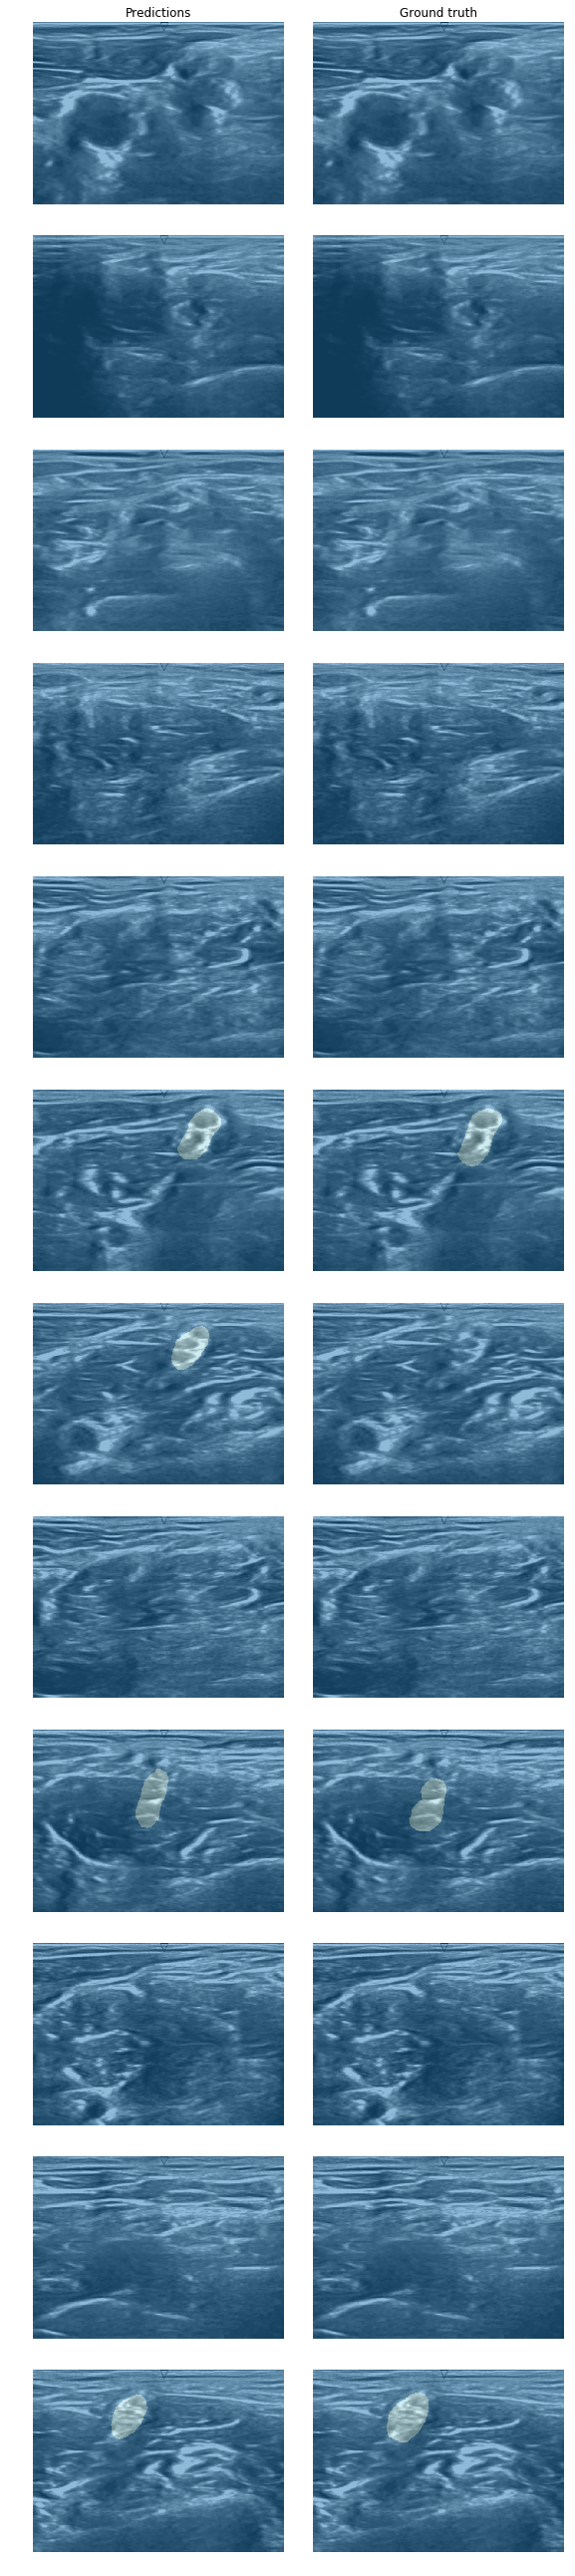

In [84]:
learn.show_results(rows = 12)

## Predictions

In [85]:
learn = Learner.create_unet(data, models.resnet34, metrics=dice)

In [87]:
learn.load('stage-8-big');

In [88]:
path_test_img = path/'test'

In [89]:
fnames_test = get_image_files(path_test_img)

In [90]:
fnames_test[:3]

[PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/test/112.tif'),
 PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/test/3375.tif'),
 PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/test/3549.tif')]

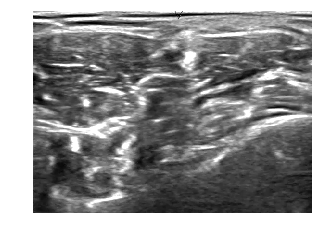

In [91]:
img_t = fnames_test[0]
img = open_image(img_t)
img.show(figsize=(5,5))

In [92]:
def grab_idx(x,i,batch_first:bool=True):
    if batch_first: return ([o[i].cpu() for o in x]   if is_listy(x) else x[i].cpu())
    else:           return ([o[:,i].cpu() for o in x] if is_listy(x) else x[:,i].cpu())

In [93]:
def seg_pred(img):
    pred = learn.predict(img)
    ds = learn.dl(DatasetType.Valid).dataset
    pred_analyze = [ds.y.analyze_pred(grab_idx(pred, i)) for i in range(1)]
    seg_mask = [ds.y.reconstruct(z) for z in pred_analyze]
    return seg_mask[0],rle_encode(seg_mask[0].data)

In [94]:
m,rle = seg_pred(img)

In [95]:
rle

'36263 12 36843 12 37415 24 37995 24 38020 1 38569 36 39149 36 39725 42 40305 42 40881 46 41461 46 42037 52 42617 52 43195 54 43775 54 44351 58 44931 58 45509 60 46089 60 46667 62 47247 62 47825 64 48405 64 48983 68 49563 68 50140 71 50720 71 51297 72 51877 72 52456 73 53036 73 53615 74 54195 74 54773 76 55353 76 55931 78 56511 78 57091 76 57671 76 58249 78 58829 78 59409 76 59989 76 60569 76 61149 76 61729 74 62309 74 62887 76 63467 76 64047 76 64627 76 65205 76 65785 76 66365 76 66945 76 67525 74 68105 74 68683 76 69263 76 69843 74 70423 74 71003 74 71583 74 72161 76 72741 76 73321 74 73901 74 74481 72 75061 72 75639 74 76219 74 76799 72 77379 72 77959 70 78539 70 79119 66 79699 66 80279 64 80859 64 81438 61 82018 61 82597 60 83177 60 83757 58 84337 58 84917 56 85497 56 86077 54 86657 54 87237 48 87817 48 88397 44 88977 44 89559 38 90139 38 90719 36 91299 36 91881 32 92461 32 93045 26 93625 26 94207 20 94787 20 95371 12 95951 12'

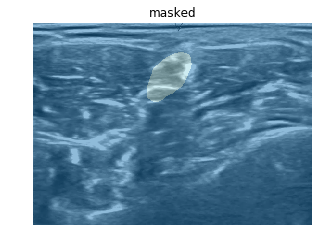

In [96]:
img.show(figsize=(5,5), y=m, title='masked')

In [97]:
path

PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation')

In [98]:
submission = pd.read_csv(path/'sample_submission.csv')

In [99]:
submission.head()

,img,pixels
0,1,1 1
1,2,1 1
2,3,1 1
3,4,1 1
4,5,1 1


In [100]:
fnames_test[0]
fnames_test[0].stem

'112'

In [101]:
fnames_test[0]

PosixPath('/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/test/112.tif')

In [102]:
img = []
pixels = []
for k in fnames_test:
    img_k = open_image(k)
    mask,rle = seg_pred(img_k)
    img.append(k.stem)
    pixels.append(rle)
    print(k)

/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/test/1266.tif


In [103]:
submission['img']=img
submission['pixels']=pixels

In [104]:
submission.head()

,img,pixels
0,112,36263 12 36843 12 37415 24 37995 24 38020 1 38...
1,3375,53717 4 54297 4 54875 8 55455 8 56035 10 56615...
2,3549,50197 4 50777 4 51349 12 51929 12 52507 14 530...
3,5075,
4,599,


In [105]:
submission = submission.replace('', np.nan, regex=True)

In [106]:
submission.head()

,img,pixels
0,112,36263 12 36843 12 37415 24 37995 24 38020 1 38...
1,3375,53717 4 54297 4 54875 8 55455 8 56035 10 56615...
2,3549,50197 4 50777 4 51349 12 51929 12 52507 14 530...
3,5075,NaN
4,599,NaN


In [107]:
submission.to_csv(path/'submission.csv',index=False)

In [108]:
from IPython.display import FileLink, FileLinks
FileLink(path/'submission.csv')

/home/jupyter/tutorials/data/ultrasound-nerve-segmentation/submission.csv

In [109]:
train_masks = pd.read_csv(path/'train_masks.csv')

In [110]:
train_masks.head()

,subject,img,pixels
0,1,1,168153 9 168570 15 168984 22 169401 26 169818 ...
1,1,2,96346 7 96762 16 97179 27 97595 35 98012 40 98...
2,1,3,121957 2 122365 26 122784 28 123202 31 123618 ...
3,1,4,110980 9 111393 21 111810 33 112228 43 112647 ...
4,1,5,NaN


In [111]:
img_k1 = open_image(fnames_test[1])
mask,rle = seg_pred(img_k1)

In [112]:
rle

'53717 4 54297 4 54875 8 55455 8 56035 10 56615 10 57193 14 57773 14 58353 16 58933 16 59513 14 60093 14 60673 14 61253 14 61835 8 62415 8 62996 5 63576 5'

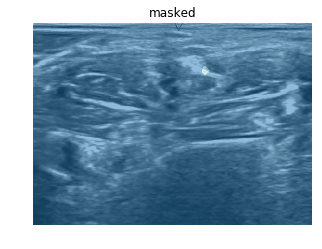

In [113]:
img_k1.show(figsize=(5,5), y=mask, title='masked')

## To Do

* Create a web application to display segmented mask